In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sps
from tqdm.notebook import tqdm
rng = np.random.default_rng()

## Постановка задачи

В этом ноутбуке рассматривается следующая задача.  
Пусть имеется граф $G$ с матрицей смежности $\{g_{ij}\}_{i, j = 1 \dots n}$. В дальнейшем всюду будем считать, что этот граф -- случайный, сгенерированный по распределению по степеням вершин $\{p_k\}$. Рассмотрим бинарные переменные $\sigma_i \in \{-1, 1\}$, соответствующие его вершинам. Конкретные принимаемые ими значения определяются функцией полезности:

$$
    U_i(\sigma_i) = H \sigma_i + H_i \sigma_i + J \sum_j g_{ij}\sigma_i \sigma_j + \varepsilon_{\sigma_i}, \\
    \sigma_i = \mathrm{argmax}(U_i(-1), U_i(1))
$$

Здесь $H$ и $J$ -- некоторые константы, отвечающие за общий вклад и взаимодействие между соседними вершинами соответственно, а $\varepsilon_{\sigma_i}$ -- случайный шум, генерирующийся заново на каждом шагу.  

Более подробно, процесс игры таков:
1. Из некоторого известного распределения случайно выбираются $H_i$.
2. Фиксируется какое-то начальное состояние системы $\{\sigma_i\}_{i = 1 \dots n}$.
3. На каждом шаге:
    1. Генерируется случайный шум $\varepsilon_{\sigma_i}$ (т.е. по 2 числа для каждой из вершин). В общем случае он зависит от имеющейся на данный момент конфигурации $\{\sigma_i\}_{i = 1 \dots n}$.
    2. В каждой вершине выбирается $\sigma_i$, максимизирующее функцию полезности.

Этот процесс можно понимать как игру, в которой агенты, находящиеся в вершинах, на каждом шаге принимают решение. Сами бинарные переменные $\sigma_i$ также будем иногда называть спинами. Пока что в этой задаче будем рассматривать случай отсутствия шума: $\varepsilon_{\sigma_i} \equiv 0$. В таком случае этот процесс может сходиться к какому-то равновесному состоянию, т.е. такому, в котором $\sigma_i$ не меняется при совершении шага 3, а может и не сходиться: например, может быть компонента связности из 2 вершин, из которых одна в отрицательном состоянии, а другая в положительном, а остальные параметры таковы, что они обе будут менять своё состояние на каждом шагу из-за того, что соседняя вершина находится в другом состоянии.


В этой задаче рассматриваются два возможных распределения по степеням вершин в графе:
1. Распределение Пуассона: $p_k = e^{-\lambda} \cfrac{\lambda^k}{k!}$
2. Степенное распределение: $p_k = \cfrac{k^{-\alpha}}{\zeta(\alpha)}$, где $\zeta(\alpha)$ -- дзета-функция Римана.

## Генерация случайного графа в рамках конфигурационной модели

Сначала исследуем пуассоновский случайный граф, потом -- со степенным распределением. Генерация случайного графа (как и весь класс для работы с ним) вынесены в отдельный файл `graph.py`. 

In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
from graph import RandomGraph, get_trajectories

Сгенерируем случайные графы. Параметры распределения выберем такими, чтобы в графе была гигантская компонента связности: $\langle k^2 \rangle - 2\langle k \rangle > 0$ (критерий Моллоя-Рида, $k$ — степень вершины). Для распределения Пуассона с параметром $\lambda$ среднее число соседей $\langle k \rangle = \lambda$, а $\langle k^2 \rangle = \lambda^2 + \lambda$, поэтому необходимо $\lambda^2 > \lambda$. Видно, что можно взять любой параметр, больший $1$. Выберем, например, $\lambda = 4$ — тогда у каждой вершины будет в среднем по $4$ соседей. 

Для степенного же распределения выберем параметр так, чтобы среднее число соседей также примерно равнялось трём. Для него $\langle k \rangle = \cfrac{\zeta(\alpha - 1)}{\zeta(\alpha)}$, так что можно взять $\alpha \approx 2{,}185$ -- тогда $\langle k \rangle \approx 4$. При таком $\alpha$ для него $\langle k^2 \rangle = +\infty$, так что гигансткая компонента связности в таком графе тоже будет.

In [4]:
N = 10000
l = 4
alpha = 2.185
G_Poisson = RandomGraph(N, sps.poisson(l))
G_zipf = RandomGraph(N, sps.zipf(alpha))

## Исследование динамики системы для $H_i \sim \mathcal{N}(0, \sigma^2)$ (одномерный случай)

Сначала рассмотрим следующий процесс: 
1. Изначально $H$ очень мало, так что для всех вершин $\sigma_i = -1$.
2. Начнём постепенно увеличивать $H$ от $H_{min}$ до $H_{max}$: при этом доля положительных спинов должна увеличиваться от $0$ при очень малых $H$ до $1$ при очень больших.
3. Затем наоборот, будем постепенно уменьшать $H$ и, соответственно, долю положительно повёрнутых спинов.

Посмотрим, насколько разными будут траектории для разных распределений $H_i$ и их параметров. В этой части рассмотрим следующие:
1. $H_i \sim \mathcal{N}(0, \sigma^2)$, рассмотрим различные $\sigma$.
2. $H_i \sim T_{\nu}$ (распределение Стьюдента), рассмотрим различные $\nu$.

Начнём с пуассоновского графа и нормального распределения $H_i$:

In [5]:
J = 0.5
sigma_min, sigma_max = 0.1, 3
sigma_grid = np.linspace(sigma_min, sigma_max, 6)

0it [00:00, ?it/s]

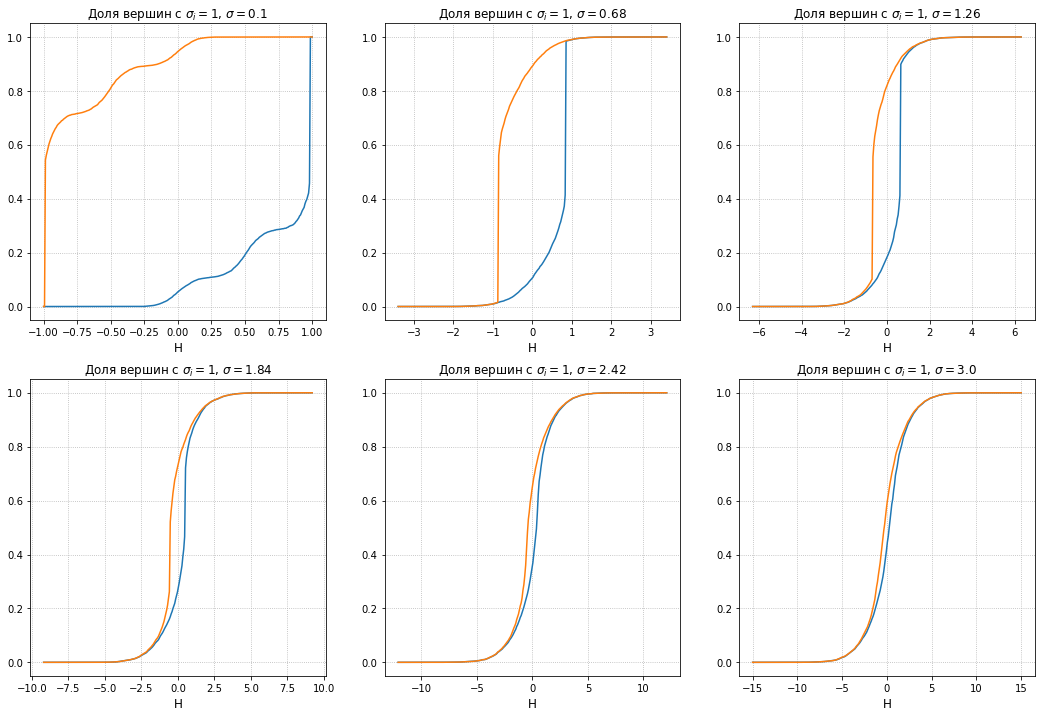

In [19]:
plt.figure(figsize=(18, 12))
for index, sigma in tqdm(enumerate(sigma_grid)):
    H_max = max(1, 5 * sigma)
    H_grid = np.linspace(-H_max, H_max, 300)
    low_to_high, high_to_low = get_trajectories(G_Poisson, J, H_grid, sigma, 'norm')
    plt.subplot(2, 3, index + 1)
    plt.plot(H_grid, low_to_high)
    plt.plot(np.flip(H_grid), high_to_low)
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\sigma = {0}$'.format(round(sigma, 3)))

Теперь посмотрим то же самое для графа со стпенным распределением $\{p_k\}$:

0it [00:00, ?it/s]

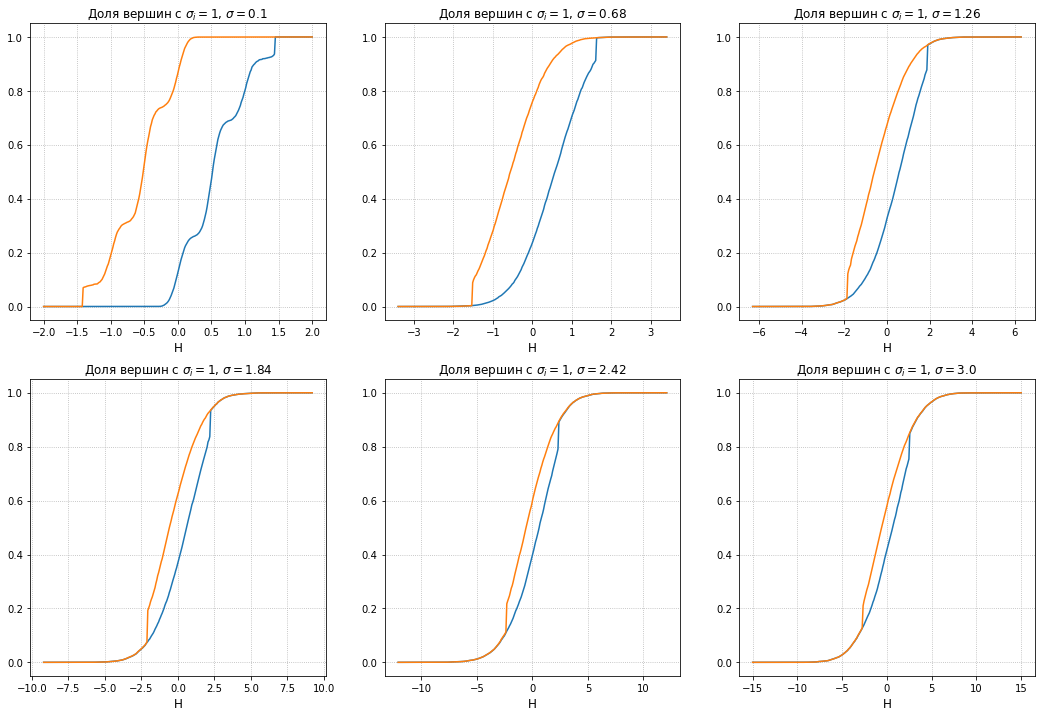

In [20]:
plt.figure(figsize=(18, 12))
for index, sigma in tqdm(enumerate(sigma_grid)):
    H_max = max(2.0, 5 * sigma)
    H_grid = np.linspace(-H_max, H_max, 300)
    low_to_high, high_to_low = get_trajectories(G_zipf, J, H_grid, sigma, 'norm')
    plt.subplot(2, 3, index + 1)
    plt.plot(H_grid, low_to_high)
    plt.plot(np.flip(H_grid), high_to_low)
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\sigma = {0}$'.format(round(sigma, 3)))

На всех графиках довольно отчётливо видна петля гистерезиса: траектории при движении $H_{min} \to H_{max}$ и $H_{max} \to H_{min}$ заметно различаются. Они начинают разделяться при некотором $H < |H*|$ — таким образом, при $H \in [-H^*, H^*] \approx [-1, 1]$ существуют по крайней мере $2$ положения равновесия.

Общий тренд одинаков как для пуассоновского графа, так и для графа со стпенным распределением -- чем меньше значение $\sigma$, тем сильнее различаются траектории. Кроме того, при очень малых $\sigma$ (порядка $0{,}1$) траектории становятся лавинообразными: видно, что вершины меняют своё состояние сразу большими группами, "лавинами". Особенно хорошо это заметно для пуассоновского графа, где в конце процесса одновременно меняют своё состояние порядка половины всех вершин.

В то же время, при увеличении $\sigma$ в пуассоновском графе этот переход стирается, траектории становятся гладкими, в то время как для графа со степенным распределением всегда остаётся резкий переход ближе к концу траектории, причём не в состояние, в котором все $\sigma_i = 1$ (или $-1$ при движении обратно), а в какое-то промежуточное, где ещё сохраняются вершины в разных состояниях. Также для графа со степенным распределением они не так сильно сближаются, как для пуассоновского.

## Исследование динамики системы для $H_i \sim T_{\nu}$ (распределение Стьюдента)

Так же, как и для нормального распределения, сравним траектории для пуассоновского графа и графа со степенным распределением:

In [13]:
freedom_grid = np.array([0.1, 0.5, 1, 2, 3.5, 5])

Пуассоновский граф:

0it [00:00, ?it/s]

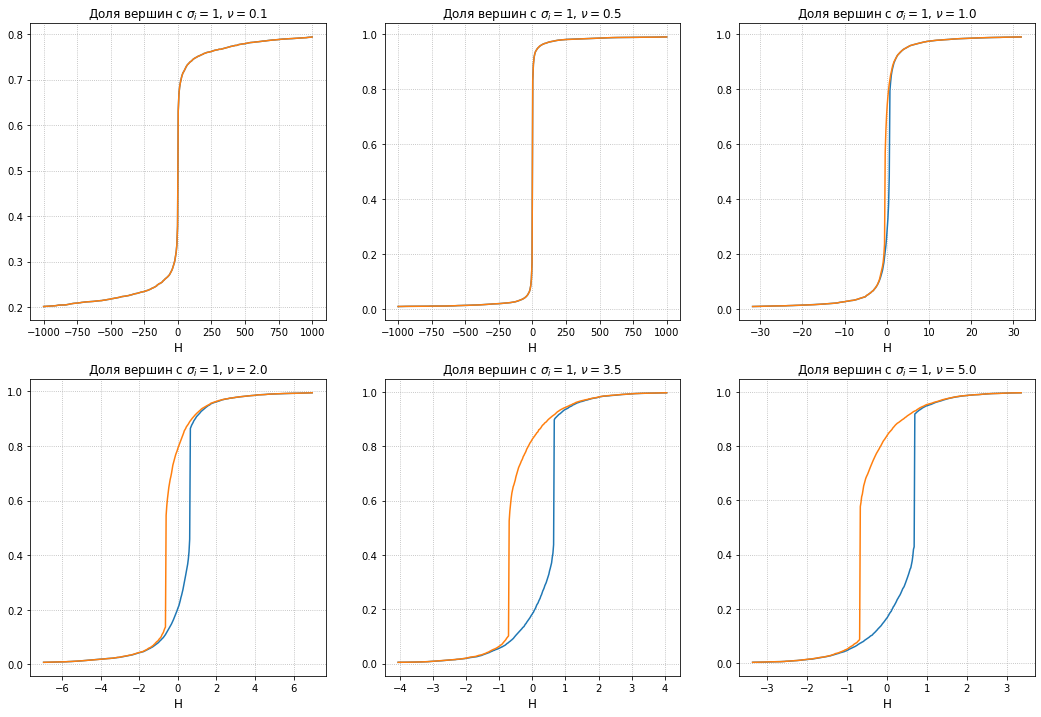

In [21]:
plt.figure(figsize=(18, 12))
for index, freedom in tqdm(enumerate(freedom_grid)):
    H_max = min(1000, sps.t.ppf(0.99, freedom))
    H_grid = np.linspace(-H_max, H_max, 400)
    low_to_high, high_to_low = get_trajectories(G_Poisson, J, H_grid, freedom, 'student')
    plt.subplot(2, 3, index + 1)
    plt.plot(H_grid, low_to_high)
    plt.plot(np.flip(H_grid), high_to_low)
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\nu = {0}$'.format(round(freedom, 3)))

Граф со степенным распределением (по степеням вершин):

0it [00:00, ?it/s]

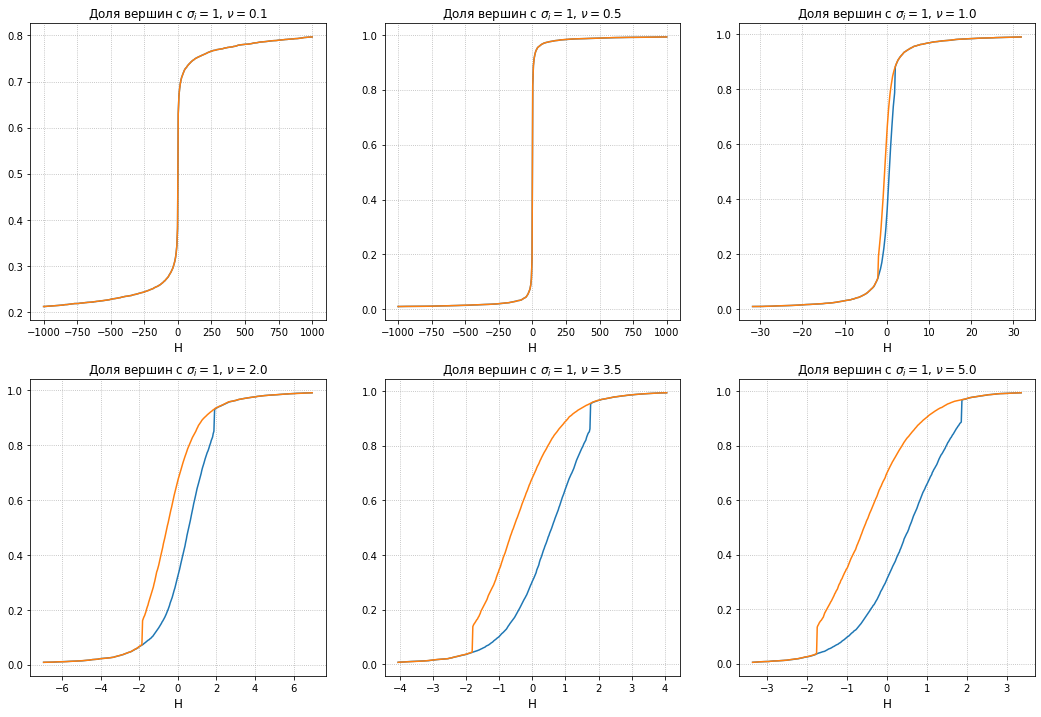

In [22]:
plt.figure(figsize=(18, 12))
for index, freedom in tqdm(enumerate(freedom_grid)):
    H_max = min(1000, sps.t.ppf(0.99, freedom))
    H_grid = np.linspace(-H_max, H_max, 400)
    low_to_high, high_to_low = get_trajectories(G_zipf, J, H_grid, freedom, 'student')
    plt.subplot(2, 3, index + 1)
    plt.plot(H_grid, low_to_high)
    plt.plot(np.flip(H_grid), high_to_low)
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\nu = {0}$'.format(round(freedom, 3)))

Как видно, в целом ситуация соответствует тому, что наблюдалось для нормального распределения. Чем меньше степень свободы (параметр распределения Стьюдента), тем более тяжёлыми становятся хвосты этого распределения, и тем менее различимы траектории. Для графа со степенным распределением графики и вовсе почти абсолютно идентичны графикам из первого пункта (где $H_i \sim \mathcal{N}(0, \sigma^2)$). Для пуассоновского же графа наблюдается одно различие: траектории не сглаживаются при увеличении дисперсии $H_i$ и утяжелении хвоста распределения, всегда остаётся определённая группа вершин, меняющаяся "скачком", что соответствует вертикальному отрезку на графиках. Впрочем, это, скорее всего, стоит более детально проверить.

## Положения равновесия

В этом пункте рассмотрим немного другую задачу: зафиксируем какое-то распределение $H_i$ (возьмём для определённости и простоты $H_i \sim \mathcal{N}(0, 1)$). Для разных значений $H$ и $J$ в системе могут быть разные положения равновесия, т.е. такие состояния, которые не меняются при совершении шага 3 из описания (обновлении $\sigma_i$ при разыгрывании шума и учёте информации о соседях). Возможны следующие ситуации:
1. Одно положение равновесия:  
    1. $\sigma_i = -1 \:\: \forall \, i$  
    2. $\sigma_i = +1 \:\: \forall \, i$ 
    3. $\langle \sigma_i \rangle = \eta \in (0, 1)$
2. Два положения равновесия:
    1. Первое: $\langle \sigma_i \rangle = 1$, второе: $\langle \sigma_i \rangle = -1$
    2. Первое: $\langle \sigma_i \rangle = 1$, второе: $\langle \sigma_i \rangle = \eta \in (0, 1)$
    3. Первое: $\langle \sigma_i \rangle = \eta \in (0, 1)$, второе: $\langle \sigma_i \rangle = -1$
    4. Первое: $\langle \sigma_i \rangle = \eta_+ \in (0, 1)$, второе: $\langle \sigma_i \rangle = \eta_- \in (0, 1)$.

Возможно, могут быть и ситуации с большим количеством положений равновесия, но пока их рассматривать не будем. Исследуем, какие случаи реализуются при разных константах $H$ и $J$. Построим по ним фазовую диаграмму.

In [12]:
N = 2000
G_Poisson = RandomGraph(N, sps.poisson(l))
G_zipf = RandomGraph(N, sps.zipf(alpha))
G_Poisson.sample_fields()
G_zipf.sample_fields()

In [7]:
H_min, H_max = -7, 7
J_min, J_max = 0, 7
H_grid = np.linspace(H_min, H_max, 200)
J_grid = np.linspace(J_min, J_max, 200)
colors = {1: '1A', 2: '1B', 3: '1C', -1: '2A', -2: '2B', -3: '2C', -4: '2D'}

In [8]:
def plot_diagram(G):
    Z = []
    for H in tqdm(np.flip(H_grid), leave=False):
        for J in tqdm(J_grid, leave=False):
            Z.append(G.get_equilibria(H, J))
    Z = np.array(Z).reshape((len(H_grid), len(J_grid)))
    plt.figure(figsize=(10, 12))
    cmap = plt.cm.get_cmap('viridis', 8)
    normalizer = mpl.colors.Normalize(-4, 3)
    plt.imshow(Z, cmap=cmap, interpolation='hamming', extent=(J_min, J_max, H_min, H_max), aspect=0.5)
    plt.xlabel('J')
    plt.ylabel('H')
    plt.legend([mpl.patches.Patch(color=cmap(normalizer(b))) for b in colors.keys()],
               list(colors.values()), fontsize='large');

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

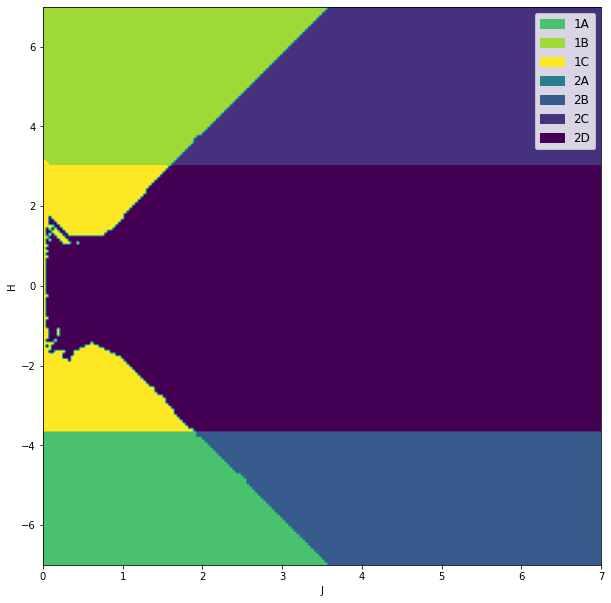

In [13]:
plot_diagram(G_Poisson)

- При малой константе связи $J$ возможны ситуации как с одним положением равновесия, так и с двумя, которые встречаются при малых H.
- При увеличении константы связи всё постепенно вытесняют ситуации с двумя положениями равновесия, что выглядит вполне логичным: если вершины в графе очень сильно взаимосвязаны между собой, то сменить состояние они могут лишь сразу все вместе, из-за чего и возникнут два положения равновесия: когда большая часть вершин положительна и когда отрицательна.
- Чётко выражена граница между тем, когда в одном из положений все вершины в одинаковом состоянии, и тем, когда это не так (на диаграмме это граница между областями $2D$ и $2B-2C$, при $|H^*| \approx 2{,}5$).
- Нет чёткой границы между областями $1C-2D$ при малых $J$, там происходит что-то хаотичное (надо будет потом посмотреть подробнее именно эту область). При больших $J$ отделяющая область $2D$ граница становится похожа на линейную, но, скорее всего, она всё же как-то более сложно описывается.

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

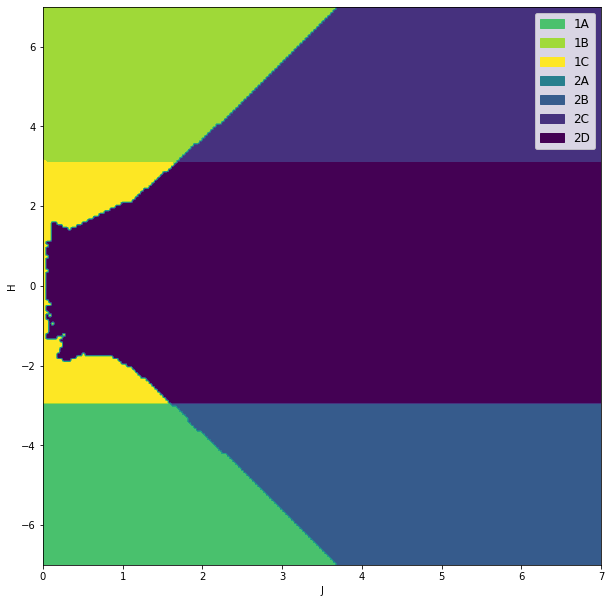

In [14]:
plot_diagram(G_zipf)

Здесь уже граница, отделяющая область $2D$ от остальных, заметно нелинейная. Эффект наличия жёлтых вкраплений области $1C$ в начале связан, вероятно, с тем, что число вершин в графе конечное, и реальное распределение по степеням лишь приближённо совпадает с тем, из чего оно генерировалось.

## Исследование динамики системы для $H_i \sim \mathcal{N}(0, \Sigma)$ (многомерный случай)

В этой части задачи предпочтения агентов скоррелированы: $H_i \sim \mathcal{N}(\vec 0, \Sigma)$, где $\Sigma$ — некоторая недиагональная матрица ковариаций. Логично предположить, что в таком случае агенты окажутся более связанными, зависимыми друг от друга, в связи с чем переходы между крайними состояниями станут более резкими, а разница траекторий — более выраженной. Посмотрим, так ли это. Однако, здесь не получится взять большое количество элементов ($10^4$, как в первом случае), т.к. иначе всё будет долго считаться, поэтому возьмём меньше: $N = 2000$.

Для начала сгенерируем матрицу ковариаций — она должна быть симметричной и неотрицательно определённой. Для этого можно взять произвольную ортогональную матрицу $P \in Mat_{N\times N}$, а $\Sigma$ восстановить по сингулярному разложению $PRP^T$, где $R$ — диагональная матрица с сингулярными числами на диагонали. Тогда $\Sigma$ будет обладать нужными свойствами. Кроме того, хочется, чтобы дисперсии не были слишком большими, поэтому возьмём сингулярные числа близкими к единичным.

In [248]:
N = 2000
alpha = 0.25
G = RandomPoissonGraph(N, l)

In [249]:
P = sps.ortho_group.rvs(G.N)
R = np.ones(G.N) + sps.uniform.rvs(loc=-alpha, scale=2.1 * alpha, size=G.N)

Sigma = P @ np.diag(R) @ P.T

In [250]:
np.min(np.diag(Sigma)), np.max(np.diag(Sigma))

(0.9939596974459893, 1.0258022055720242)

In [251]:
G.sample_fields(sps.multivariate_normal(np.zeros(G.N), Sigma), multivariate=True)

Точно так же, как в первой части, будем плавно изменять $H$, сначала повышая его, а потом понижая.

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.24it/s]


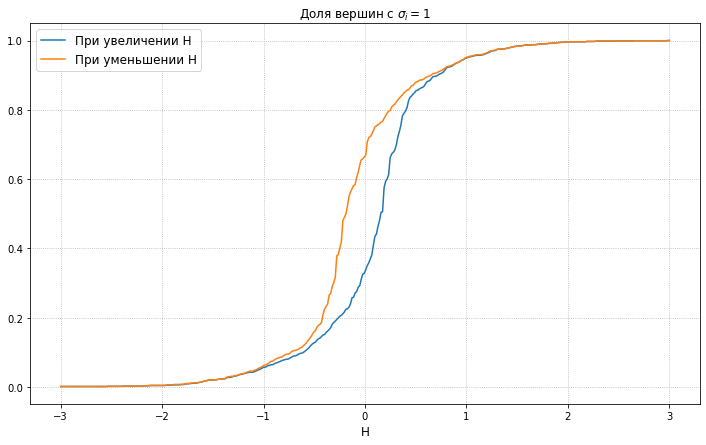

In [252]:
low_to_high_fractions = []
for H in tqdm(H_grid):
    new_state = get_stable_state(G, H, J)
    low_to_high_fractions.append(np.mean(new_state + 1) / 2)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('H', fontsize='large')
plt.title(r'Доля вершин с $\sigma_i = 1$')
plt.plot(H_grid, low_to_high_fractions, label="При увеличении H");

high_to_low_fractions = []
for H in tqdm(np.flip(H_grid)):
    new_state = get_stable_state(G, H, J)
    high_to_low_fractions.append(np.mean(new_state + 1) / 2)
plt.plot(np.flip(H_grid), high_to_low_fractions, label='При уменьшении H');
plt.legend(fontsize='large');

Переходы и правда стали более резкими — видимо, из-за того, что соседние вершины более "связаны", они могут поменять своё состояние лишь сразу всей группой, в то время как в первой части более вероятны переходы отдельных вершин даже с большой степенью. Кроме того, можно заметить, что петля немного сдвинута вправо от нуля (впрочем, возможно, это какой-то случайный эффект). Само же разделение траекторий начинается, как и в первой части, при $|H| \approx 1$, а при малых по модулю $H$ наблюдаются два возможных положения равновесия.

## Как именно устанавливаются положения равновесия?

Рассмотрим следующую задачу. Пусть изначально все $\sigma_i = -1$, но $H$ фиксировано и близко к $0$, так что это состояние не является равновесным. Оно, однако, будет постепенно сходиться к какому-то положению равновесия:
1. Сначала поменяют своё состояние те агенты, для которых $H + H_i - Jk > 0$ — они желают быть "положительными" вне зависимости от того, что выбирают их соседи.
2. Потом поменяют своё состояние те их соседи, для перехода которых в положительное состояние достаточно одной положительной смежной вершины, т.е. те, для которых $H + H_i - J(k - 1) > 0$. Также возможна ситуация, когда какая-то вершина смежна сразу с несколькими сменившими состояние на первом шаге, и для неё достаточно имеющегося количества положительных соседей — тогда она тоже сменит состояние на этом шаге.
3. Затем добавятся соседи вершин, развернувшихся на втором шаге, для которых уже есть необходимая доля положительных соседей, и т.д.  

Таким образом, процесс перехода вершин в положительное состояние начинается с отдельных "центров" и постепенно распространяется от них по всему графу. Посмотрим, как именно происходит этот процесс: какие доли вершин становятся положительными на разных шагах.

In [329]:
N = 10000
H = 0
J = 0.2
new_fractions = []

In [330]:
G = RandomPoissonGraph(N, l)
G.sample_fields()

In [331]:
G.set_state(-np.ones(G.N))

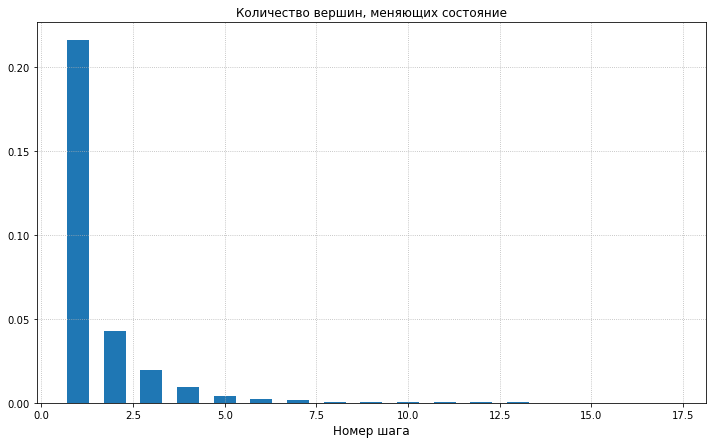

In [332]:
current_state = G.state
next_state = G.get_next_state(H, J)
while not np.allclose(current_state, next_state):
    new_fractions.append(np.mean(next_state - current_state) / 2)
    current_state = next_state
    next_state = G.get_next_state(H, J)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('Номер шага', fontsize='large')
plt.title(r'Количество вершин, меняющих состояние')
plt.bar(range(1, len(new_fractions) + 1), new_fractions, width=0.6);

Очень много вершин меняют своё состояние на первом же шаге, после чего изменения довольно быстро затухают, за 10-20 шагов сходясь к равновесному состоянию. Стало быть, влияние соседей оказывается не столь сильным, в основном состояние агента определяется его индивидуальным полем $H_i$. Попробуем увеличить константу $J$, отвечающую за силу взаимодействия:

In [334]:
J = 1

In [335]:
G = RandomPoissonGraph(N, l)
G.sample_fields(sps.norm(loc=0, scale=3))
G.set_state(-np.ones(G.N))

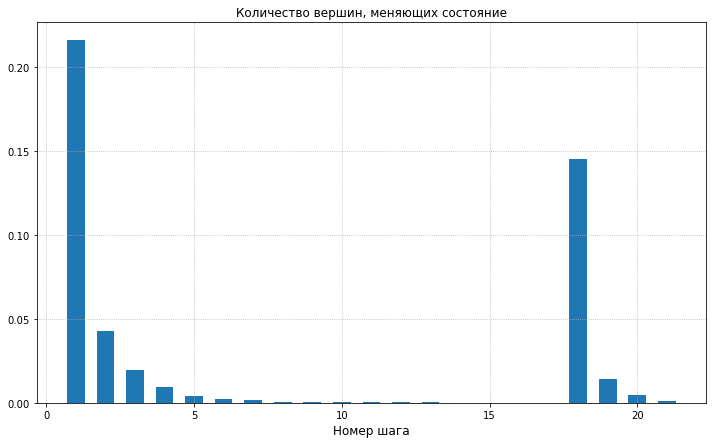

In [336]:
current_state = G.state
next_state = G.get_next_state(H, J)
while not np.allclose(current_state, next_state):
    new_fractions.append(np.mean(next_state - current_state) / 2)
    current_state = next_state
    next_state = G.get_next_state(H, J)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('Номер шага', fontsize='large')
plt.title(r'Количество вершин, меняющих состояние')
plt.bar(range(1, len(new_fractions) + 1), new_fractions, width=0.6);

Как видно, ситуация приниципиально поменялась — появились 2 волны "переворачивания" спинов, выглядящие так же, как на в первой ситуации: довольно много вершин переворачиваются на первом шаге, а потом процесс довольно быстро затухает. Вершины с $\sigma_i = +1$ постепенно скапливаются, после чего наступает вторая волна, в которой также довольно большая доля вершин меняет своё состояние.

Почему же появляется вторая волна? Вероятно, в конце первой волны складывается ситуация, в которой какой-то отдельный кластер вершин ещё не сменил состояние, но близок к этому. После этого одна из его вершин меняет своё состояние, и этого оказывается достаточно, чтобы на следующем шаге весь этот кластер тоже изменил его — здесь уже, в отличие от первого случая, виден эффект, связанный с сильным влиянием соседей. Далее вершины этого кластера, в свою очередь, вызывают изменения у соседей, и процесс дальше распространяется по графу, как и при первой волне.